In [1]:
# Imports we will use
import torch
import gc
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Function
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import random
from pathlib import Path
from sklearn.metrics import r2_score
from astropy.visualization import make_lupton_rgb
from sklearn.manifold import Isomap
from train_utils import *
import time
import os
import json

%matplotlib inline
plt.rcParams.update({'font.size': 12})

# Find if cuda is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [2]:
#fix seed
seed = 13
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.enabled=False
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(seed)

## Load Data

In [3]:
# Specify paths, load in data, and subsample labels
head = Path.cwd().parents[1]
source_img_path = head / 'data/mb_paper_source_final/mb_paper_source_final.npy'
target_img_path = head / 'data/mb_paper_target_final/mb_paper_target_final.npy'
source_meta = head / 'data/mb_paper_source_final/mb_paper_source_final_metadata.csv'
target_meta = head / 'data/mb_paper_target_final/mb_paper_target_final_metadata.csv'
batch_size = 128
source_train_dataloader, source_test_dataloader, source_val_dataloader, source_data = create_dataloader(source_img_path, source_meta, batch_size)
target_train_dataloader, target_test_dataloader, target_val_dataloader, target_data = create_dataloader(target_img_path, target_meta, batch_size)
isomap_source_label_sample = pd.read_csv(source_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]
isomap_target_label_sample = pd.read_csv(target_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]

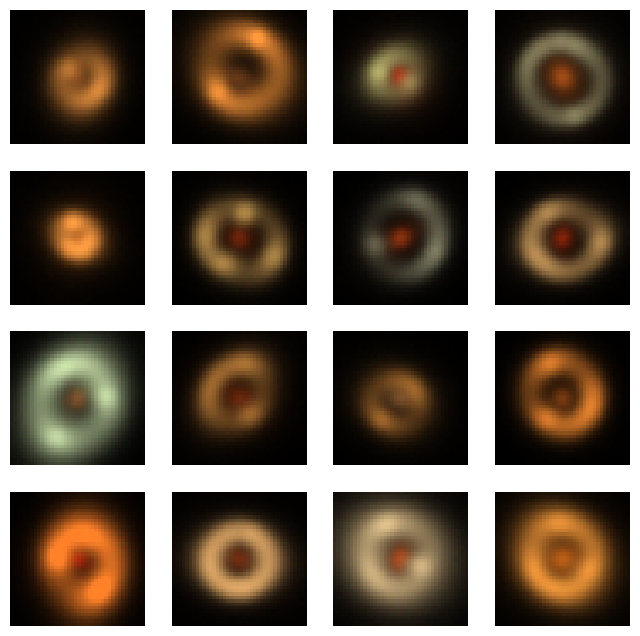

In [4]:
# Visualize source data
visualize_data(source_data)

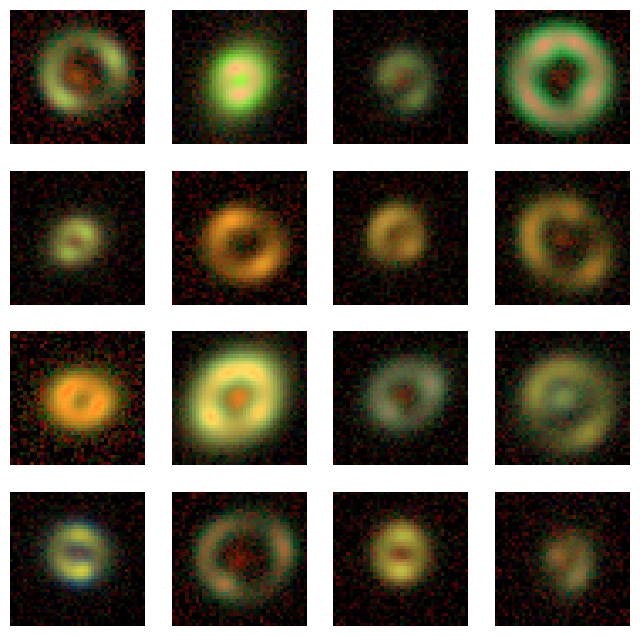

In [5]:
# Visualize target data
visualize_data(target_data)

## Model Setup

In [6]:
# Choose how you prefer to evolve beta and the DA Weight
def da_weight_function(epoch):
    """ Linear evolving DA weighting in loss function. """
    # if epoch < evolv_epoch_da:
    #     da_weight = init_wt_da - ((init_wt_da - final_wt_da) * (epoch / evolv_epoch_da))
    # else:
    #     da_weight = final_wt_da
    return 1.4

def beta_function(epoch):
    """ Linear evolving beta weighting in loss function until halfway through total epochs. """
    if epoch < evolv_epoch_beta:
        beta_val = beta_init - (beta_init - beta_final) * (epoch / evolv_epoch_beta)
    elif epoch < evolv_epoch_nll:
        beta_val = beta_final
    else:
        beta_val = 0.0
    return beta_val

# Initialize hyperparameters
learning_rate = 3e-5

n_epoch = 250
evolv_epoch_beta = 150
evolv_epoch_nll = 200
#evolv_epoch_da = 250

beta_init = 1.0
beta_final = 0.5

# init_wt_da = 1.4
# final_wt_da = 1.0

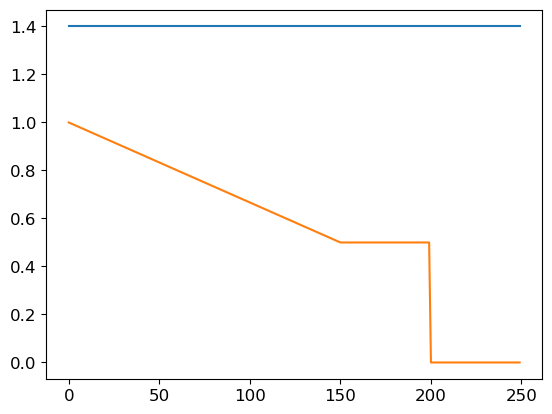

In [7]:
s = np.arange(250)
plt.plot(s, [da_weight_function(i) for i in s])
plt.plot(s, [beta_function(i) for i in s])

In [8]:
from torch.optim.lr_scheduler import MultiStepLR
# Initialize model
model = NeuralNetworkMVE(npix=40).cuda()

# Loss Functions / Optimizers
regressor_loss_fn = nn.MSELoss().cuda()
da_loss_fn = MMD_loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = MultiStepLR(optimizer, milestones=[200], gamma=0.04)

In [9]:
# To continue training from a past model, enter path into load_mod_name
# Else, enter None, and you still have to run the function.
# Then, enter save_mod_name to save for the current run  

load_mod_name = None 
stats, model, optimizer, best_target_R2, best_mve_loss, best_nll_loss = initialize_state(load_mod_name, model, optimizer)


#save_mod_name = load_mod_name # may overwrite loaded model
save_mod_name = "models/papermve_v4_aug24_1220"

## Train

Beginning Training...
Generating Isomap...


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


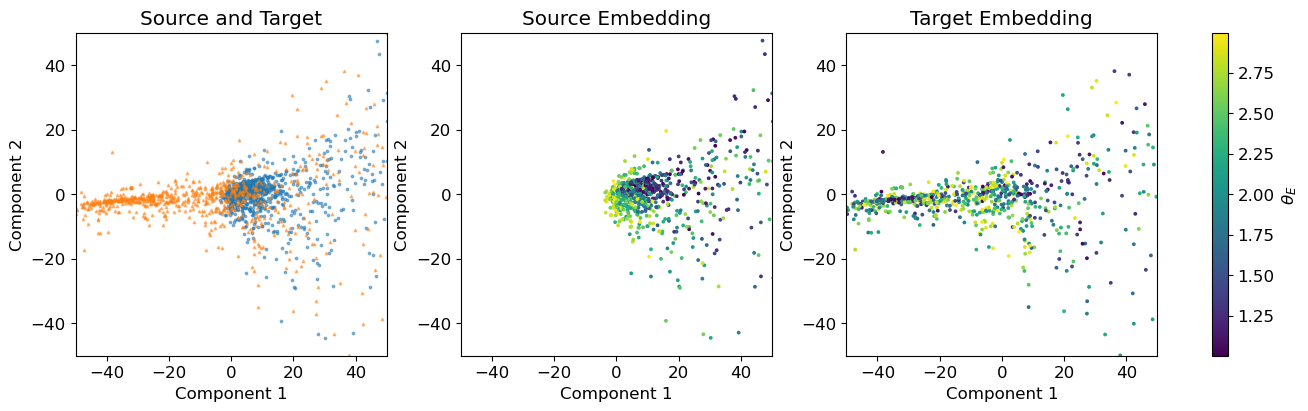


Epoch 0: 42.40s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.4657
	Train Regression Loss: : 2.0740
	Train Mve Loss: : 0.8835
	Train R2 Score: : -5.3215
 Validation Statistics:
	Val Source Regression Loss: : 0.7792
	Val Target Regression Loss: : 0.7237
	Val Source R2 Score: : -1.3843
	Val Target R2 Score: : -1.1479
	Val Source Mve Loss: : 0.2336
	Val Target Mve Loss: : 0.2026
	Val Source Nll Loss: : 0.4683
	Val Target Nll Loss: : 0.4784
Saving Model MVE... Done.
Saving Model NLL... Done.

Epoch 1: 50.13s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.3152
	Train Regression Loss: : 0.4476
	Train Mve Loss: : 0.0647
	Train R2 Score: : -0.3531
 Validation Statistics:
	Val Source Regression Loss: : 0.2847
	Val Target Regression Loss: : 0.2972
	Val Source R2 Score: : 0.1323
	Val Target R2 Score: : 0.1141
	Val Source Mve Loss: : -0.0216
	Val Target Mve Loss: : -0.0199
	Val Source Nll Loss: : -0.0726
	Val Target Nll Loss: : -0.0428
Saving

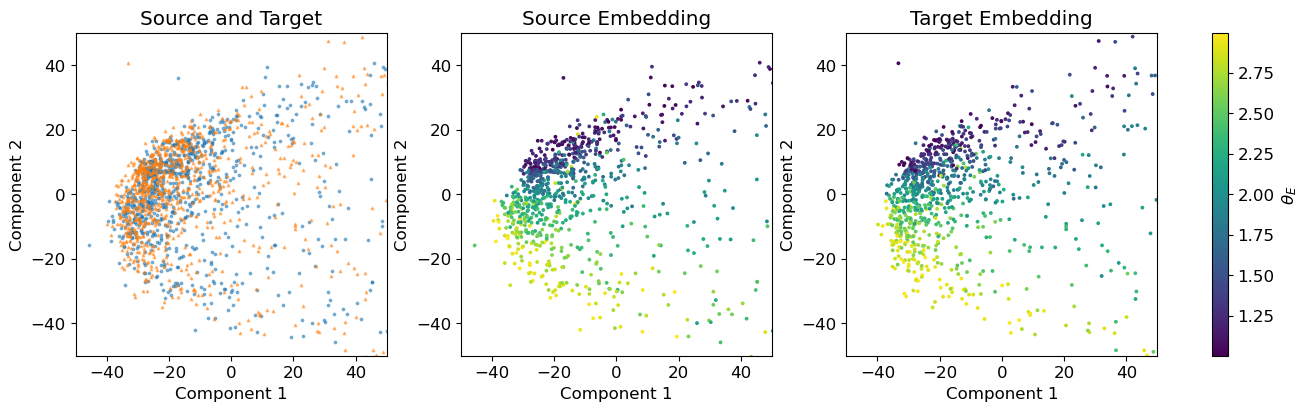


Epoch 20: 43.52s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0302
	Train Regression Loss: : 0.0175
	Train Mve Loss: : -0.0836
	Train R2 Score: : 0.9471
 Validation Statistics:
	Val Source Regression Loss: : 0.0176
	Val Target Regression Loss: : 0.0230
	Val Source R2 Score: : 0.9461
	Val Target R2 Score: : 0.9311
	Val Source Mve Loss: : -0.0603
	Val Target Mve Loss: : -0.0579
	Val Source Nll Loss: : 7494.9431
	Val Target Nll Loss: : 9312.5680

Epoch 21: 48.54s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0293
	Train Regression Loss: : 0.0170
	Train Mve Loss: : -0.0627
	Train R2 Score: : 0.9484
 Validation Statistics:
	Val Source Regression Loss: : 0.0170
	Val Target Regression Loss: : 0.0234
	Val Source R2 Score: : 0.9479
	Val Target R2 Score: : 0.9305
	Val Source Mve Loss: : -0.0600
	Val Target Mve Loss: : -0.0580
	Val Source Nll Loss: : 4696.3943
	Val Target Nll Loss: : 6536.0683

Epoch 22: 49.36s
----------------------------

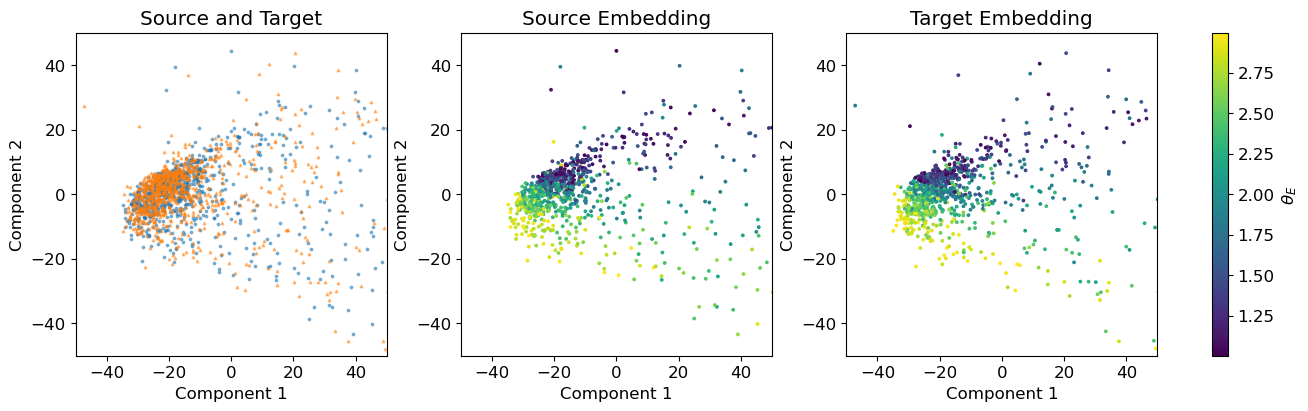

Saving Model... Done.

Epoch 40: 47.02s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0247
	Train Regression Loss: : 0.0147
	Train Mve Loss: : -0.0683
	Train R2 Score: : 0.9553
 Validation Statistics:
	Val Source Regression Loss: : 0.0146
	Val Target Regression Loss: : 0.0211
	Val Source R2 Score: : 0.9552
	Val Target R2 Score: : 0.9372
	Val Source Mve Loss: : -0.0705
	Val Target Mve Loss: : -0.0685
	Val Source Nll Loss: : 3527.9424
	Val Target Nll Loss: : 3601.3787
Saving Model... Done.

Epoch 41: 51.32s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0242
	Train Regression Loss: : 0.0143
	Train Mve Loss: : -0.0769
	Train R2 Score: : 0.9568
 Validation Statistics:
	Val Source Regression Loss: : 0.0141
	Val Target Regression Loss: : 0.0200
	Val Source R2 Score: : 0.9566
	Val Target R2 Score: : 0.9405
	Val Source Mve Loss: : -0.0568
	Val Target Mve Loss: : -0.0557
	Val Source Nll Loss: : 3995.9110
	Val Target Nll Loss: : 4047.0326
Sa

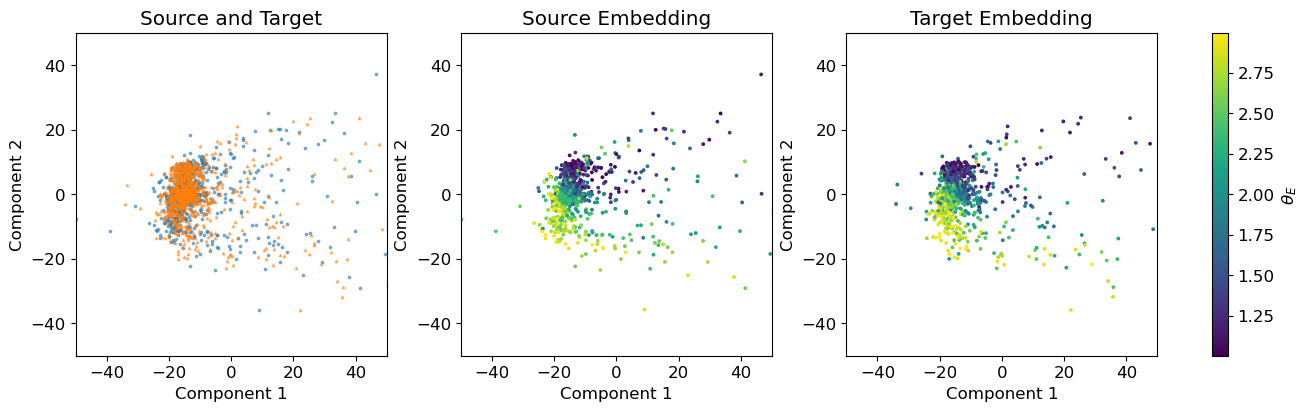


Epoch 60: 48.54s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0184
	Train Regression Loss: : 0.0121
	Train Mve Loss: : -0.0783
	Train R2 Score: : 0.9634
 Validation Statistics:
	Val Source Regression Loss: : 0.0119
	Val Target Regression Loss: : 0.0163
	Val Source R2 Score: : 0.9635
	Val Target R2 Score: : 0.9512
	Val Source Mve Loss: : -0.0729
	Val Target Mve Loss: : -0.0764
	Val Source Nll Loss: : 1344.7895
	Val Target Nll Loss: : 1631.8674

Epoch 61: 48.56s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0175
	Train Regression Loss: : 0.0124
	Train Mve Loss: : -0.1286
	Train R2 Score: : 0.9624
 Validation Statistics:
	Val Source Regression Loss: : 0.0123
	Val Target Regression Loss: : 0.0197
	Val Source R2 Score: : 0.9623
	Val Target R2 Score: : 0.9410
	Val Source Mve Loss: : -0.1693
	Val Target Mve Loss: : -0.1654
	Val Source Nll Loss: : -1.0395
	Val Target Nll Loss: : 626.6526

Epoch 62: 49.00s
-------------------------------

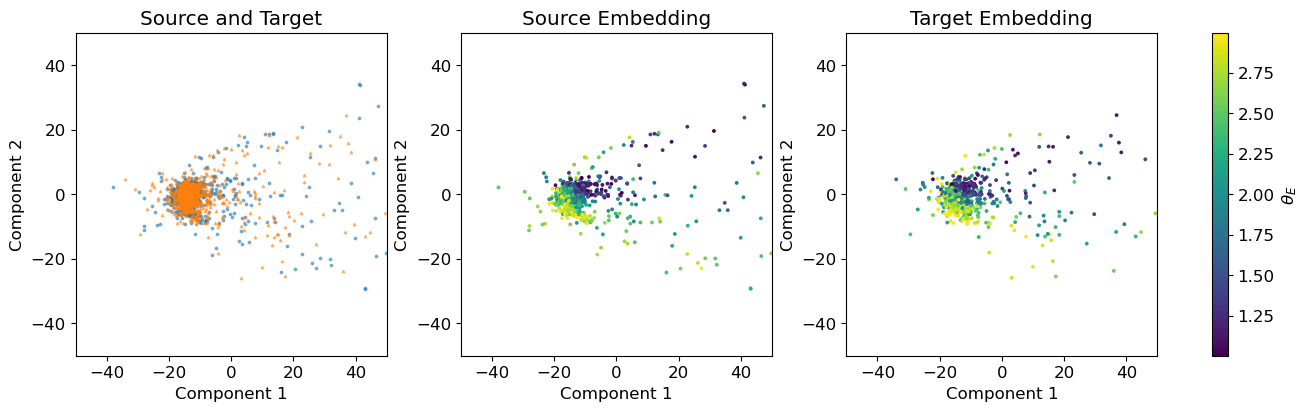


Epoch 80: 44.09s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0163
	Train Regression Loss: : 0.0129
	Train Mve Loss: : -0.1794
	Train R2 Score: : 0.9608
 Validation Statistics:
	Val Source Regression Loss: : 0.0127
	Val Target Regression Loss: : 0.0174
	Val Source R2 Score: : 0.9607
	Val Target R2 Score: : 0.9475
	Val Source Mve Loss: : -0.1588
	Val Target Mve Loss: : -0.1553
	Val Source Nll Loss: : 879.2165
	Val Target Nll Loss: : 1064.1864

Epoch 81: 48.97s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0160
	Train Regression Loss: : 0.0130
	Train Mve Loss: : -0.1428
	Train R2 Score: : 0.9606
 Validation Statistics:
	Val Source Regression Loss: : 0.0136
	Val Target Regression Loss: : 0.0196
	Val Source R2 Score: : 0.9580
	Val Target R2 Score: : 0.9422
	Val Source Mve Loss: : -0.2139
	Val Target Mve Loss: : -0.2129
	Val Source Nll Loss: : -0.8561
	Val Target Nll Loss: : -0.8175

Epoch 82: 51.84s
-------------------------------
 

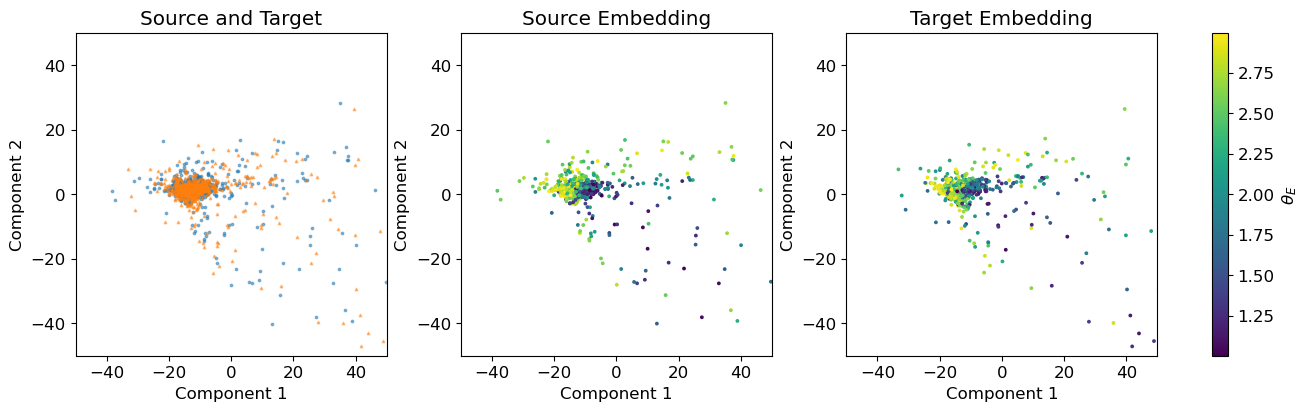


Epoch 100: 43.68s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0142
	Train Regression Loss: : 0.0126
	Train Mve Loss: : -0.2100
	Train R2 Score: : 0.9617
 Validation Statistics:
	Val Source Regression Loss: : 0.0124
	Val Target Regression Loss: : 0.0179
	Val Source R2 Score: : 0.9621
	Val Target R2 Score: : 0.9468
	Val Source Mve Loss: : -0.2319
	Val Target Mve Loss: : -0.2268
	Val Source Nll Loss: : 16.9813
	Val Target Nll Loss: : 140.0005

Epoch 101: 41.43s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0142
	Train Regression Loss: : 0.0125
	Train Mve Loss: : -0.1870
	Train R2 Score: : 0.9621
 Validation Statistics:
	Val Source Regression Loss: : 0.0126
	Val Target Regression Loss: : 0.0190
	Val Source R2 Score: : 0.9612
	Val Target R2 Score: : 0.9435
	Val Source Mve Loss: : -0.2324
	Val Target Mve Loss: : -0.2253
	Val Source Nll Loss: : 152.7272
	Val Target Nll Loss: : 272.9219

Epoch 102: 45.62s
------------------------------

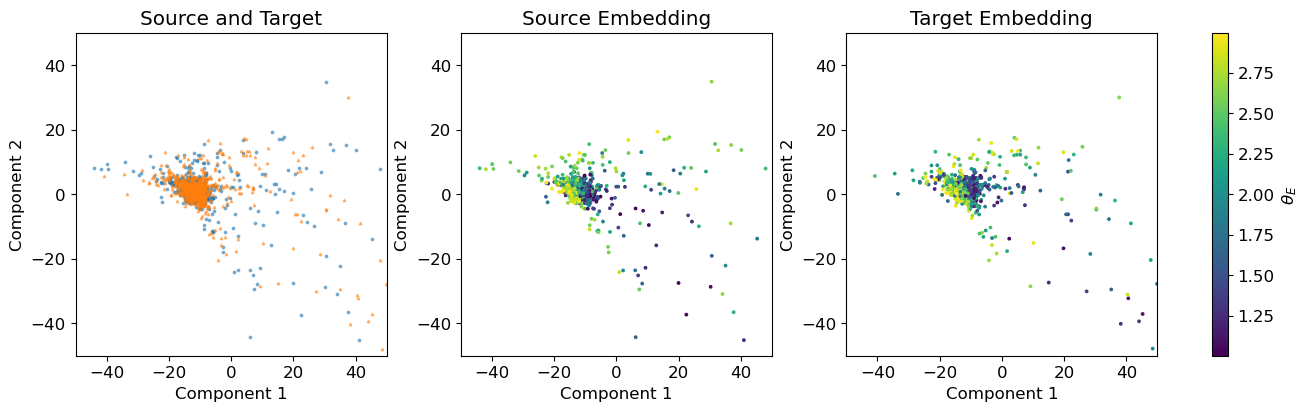


Epoch 120: 44.48s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0134
	Train Regression Loss: : 0.0133
	Train Mve Loss: : -0.2834
	Train R2 Score: : 0.9596
 Validation Statistics:
	Val Source Regression Loss: : 0.0130
	Val Target Regression Loss: : 0.0177
	Val Source R2 Score: : 0.9597
	Val Target R2 Score: : 0.9476
	Val Source Mve Loss: : -0.2876
	Val Target Mve Loss: : -0.2837
	Val Source Nll Loss: : -0.7987
	Val Target Nll Loss: : -0.7786
Saving Model MVE... Done.

Epoch 121: 50.45s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0137
	Train Regression Loss: : 0.0129
	Train Mve Loss: : -0.2889
	Train R2 Score: : 0.9609
 Validation Statistics:
	Val Source Regression Loss: : 0.0129
	Val Target Regression Loss: : 0.0171
	Val Source R2 Score: : 0.9605
	Val Target R2 Score: : 0.9489
	Val Source Mve Loss: : -0.2880
	Val Target Mve Loss: : -0.2846
	Val Source Nll Loss: : -0.8389
	Val Target Nll Loss: : -0.8179
Saving Model MVE... Done.


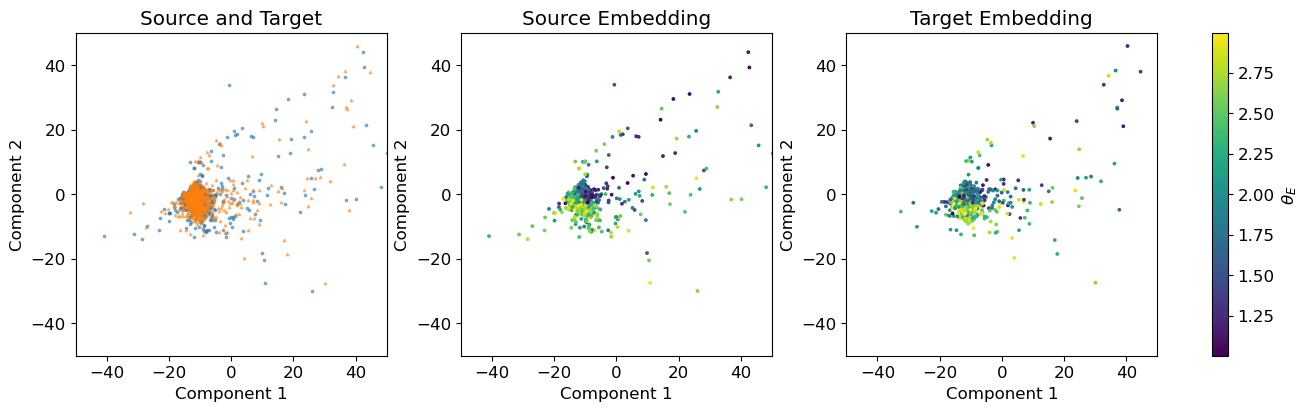


Epoch 140: 46.15s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0127
	Train Regression Loss: : 0.0125
	Train Mve Loss: : -0.0943
	Train R2 Score: : 0.9622
 Validation Statistics:
	Val Source Regression Loss: : 0.0135
	Val Target Regression Loss: : 0.0176
	Val Source R2 Score: : 0.9581
	Val Target R2 Score: : 0.9449
	Val Source Mve Loss: : 0.0190
	Val Target Mve Loss: : 0.3455
	Val Source Nll Loss: : 1774.8590
	Val Target Nll Loss: : 3525.1158

Epoch 141: 55.20s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0128
	Train Regression Loss: : 0.0128
	Train Mve Loss: : -0.2613
	Train R2 Score: : 0.9610
 Validation Statistics:
	Val Source Regression Loss: : 0.0124
	Val Target Regression Loss: : 0.0192
	Val Source R2 Score: : 0.9617
	Val Target R2 Score: : 0.9428
	Val Source Mve Loss: : -0.3286
	Val Target Mve Loss: : -0.3210
	Val Source Nll Loss: : -0.8073
	Val Target Nll Loss: : -0.7847
Saving Model MVE... Done.

Epoch 142: 50.10s
-----

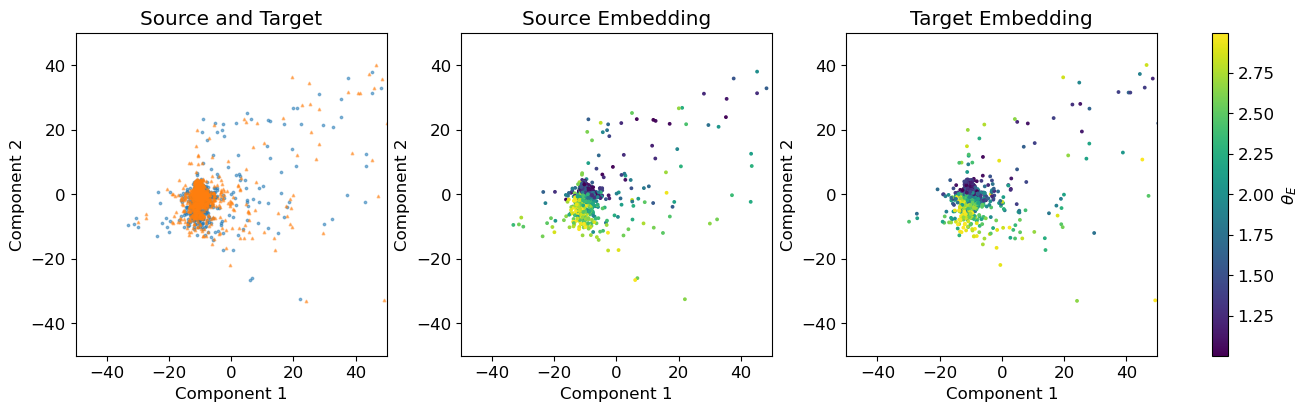


Epoch 160: 40.15s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0131
	Train Regression Loss: : 0.0119
	Train Mve Loss: : -0.2705
	Train R2 Score: : 0.9640
 Validation Statistics:
	Val Source Regression Loss: : 0.0112
	Val Target Regression Loss: : 0.0190
	Val Source R2 Score: : 0.9659
	Val Target R2 Score: : 0.9426
	Val Source Mve Loss: : -0.1171
	Val Target Mve Loss: : -0.0488
	Val Source Nll Loss: : 565.4270
	Val Target Nll Loss: : 741.7812

Epoch 161: 42.44s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0125
	Train Regression Loss: : 0.0114
	Train Mve Loss: : -0.2692
	Train R2 Score: : 0.9654
 Validation Statistics:
	Val Source Regression Loss: : 0.0113
	Val Target Regression Loss: : 0.0199
	Val Source R2 Score: : 0.9654
	Val Target R2 Score: : 0.9410
	Val Source Mve Loss: : -0.3240
	Val Target Mve Loss: : 0.6737
	Val Source Nll Loss: : -1.1220
	Val Target Nll Loss: : 3108.6512

Epoch 162: 44.71s
------------------------------

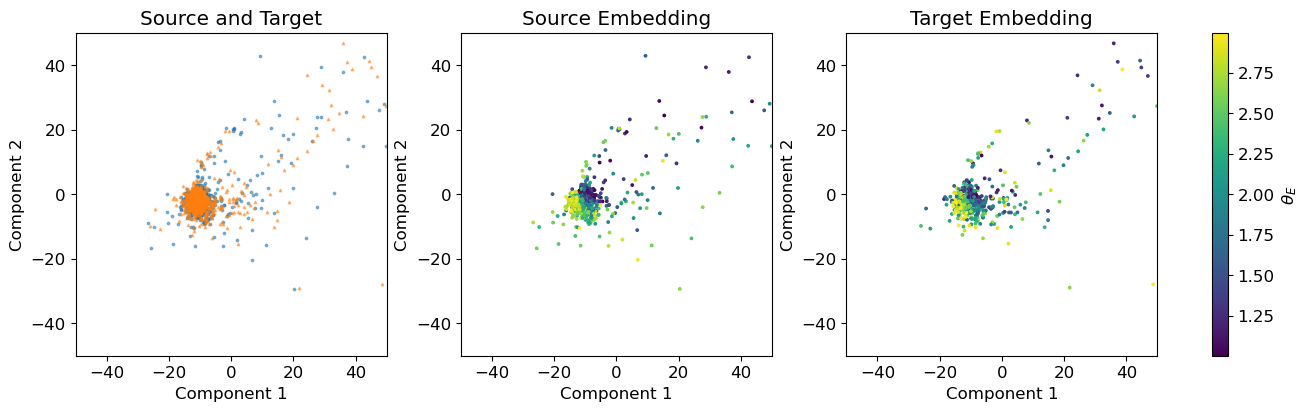


Epoch 180: 48.25s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0124
	Train Regression Loss: : 0.0128
	Train Mve Loss: : -0.3403
	Train R2 Score: : 0.9614
 Validation Statistics:
	Val Source Regression Loss: : 0.0129
	Val Target Regression Loss: : 0.0181
	Val Source R2 Score: : 0.9611
	Val Target R2 Score: : 0.9460
	Val Source Mve Loss: : -0.3409
	Val Target Mve Loss: : -0.3356
	Val Source Nll Loss: : -0.6942
	Val Target Nll Loss: : -0.7581

Epoch 181: 51.14s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0128
	Train Regression Loss: : 0.0124
	Train Mve Loss: : -0.3414
	Train R2 Score: : 0.9626
 Validation Statistics:
	Val Source Regression Loss: : 0.0123
	Val Target Regression Loss: : 0.0178
	Val Source R2 Score: : 0.9624
	Val Target R2 Score: : 0.9474
	Val Source Mve Loss: : -0.3403
	Val Target Mve Loss: : -0.3364
	Val Source Nll Loss: : 5.0558
	Val Target Nll Loss: : -0.7674

Epoch 182: 48.83s
-------------------------------
 T

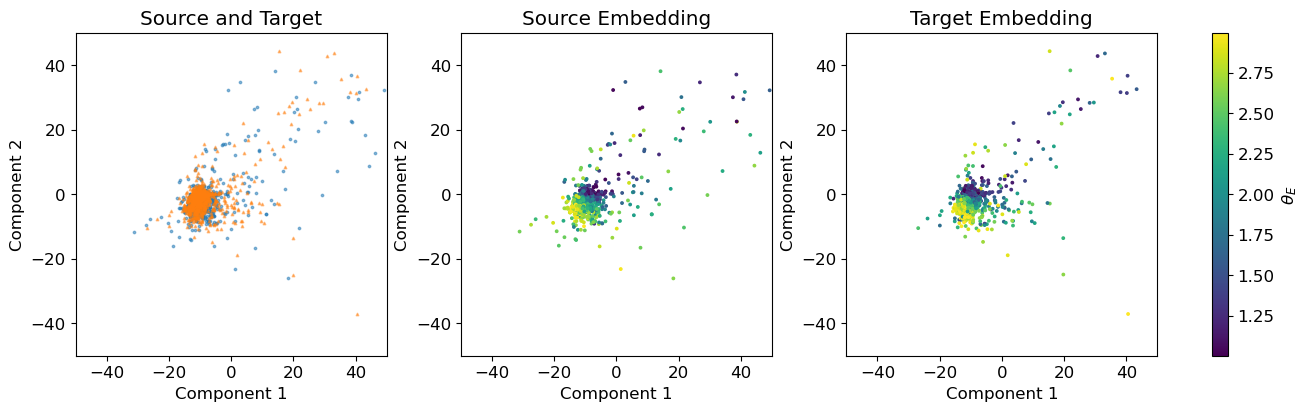


Epoch 200: 48.50s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0129
	Train Regression Loss: : 0.0107
	Train Mve Loss: : 19.8606
	Train R2 Score: : 0.9674
 Validation Statistics:
	Val Source Regression Loss: : 0.0108
	Val Target Regression Loss: : 0.0169
	Val Source R2 Score: : 0.9672
	Val Target R2 Score: : 0.9496
	Val Source Mve Loss: : 8.9627
	Val Target Mve Loss: : 87.8900
	Val Source Nll Loss: : 8.9627
	Val Target Nll Loss: : 87.8900

Epoch 201: 47.56s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0128
	Train Regression Loss: : 0.0107
	Train Mve Loss: : 17.4905
	Train R2 Score: : 0.9677
 Validation Statistics:
	Val Source Regression Loss: : 0.0106
	Val Target Regression Loss: : 0.0175
	Val Source R2 Score: : 0.9677
	Val Target R2 Score: : 0.9481
	Val Source Mve Loss: : 17.8977
	Val Target Mve Loss: : 58.2092
	Val Source Nll Loss: : 17.8977
	Val Target Nll Loss: : 58.2092

Epoch 202: 46.54s
-------------------------------
 Tr

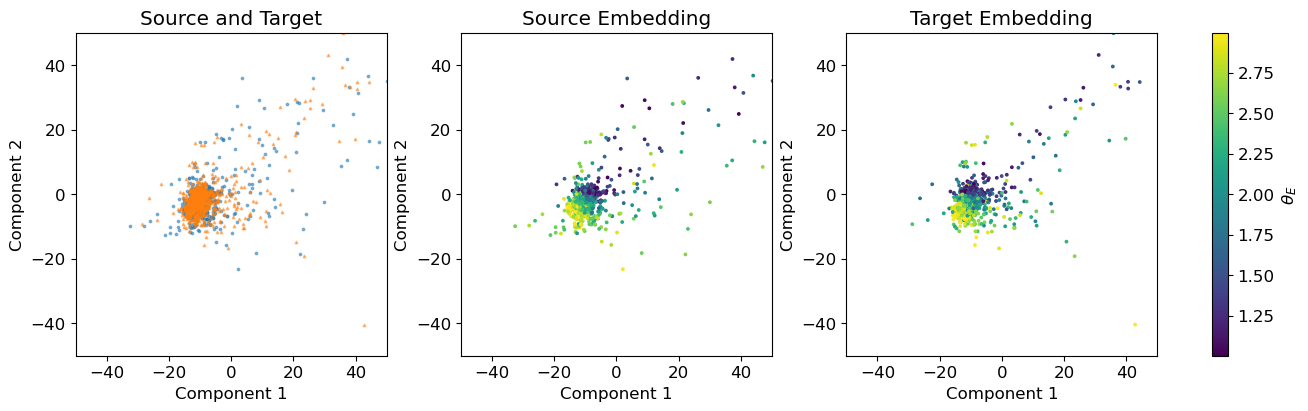


Epoch 220: 49.79s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0127
	Train Regression Loss: : 0.0107
	Train Mve Loss: : 3.2424
	Train R2 Score: : 0.9677
 Validation Statistics:
	Val Source Regression Loss: : 0.0107
	Val Target Regression Loss: : 0.0178
	Val Source R2 Score: : 0.9673
	Val Target R2 Score: : 0.9471
	Val Source Mve Loss: : -1.4855
	Val Target Mve Loss: : 87.1924
	Val Source Nll Loss: : -1.4855
	Val Target Nll Loss: : 87.1924

Epoch 221: 50.19s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0137
	Train Regression Loss: : 0.0108
	Train Mve Loss: : 5.0381
	Train R2 Score: : 0.9674
 Validation Statistics:
	Val Source Regression Loss: : 0.0110
	Val Target Regression Loss: : 0.0181
	Val Source R2 Score: : 0.9664
	Val Target R2 Score: : 0.9463
	Val Source Mve Loss: : -1.0317
	Val Target Mve Loss: : 104.9798
	Val Source Nll Loss: : -1.0317
	Val Target Nll Loss: : 104.9798

Epoch 222: 46.22s
-------------------------------
 

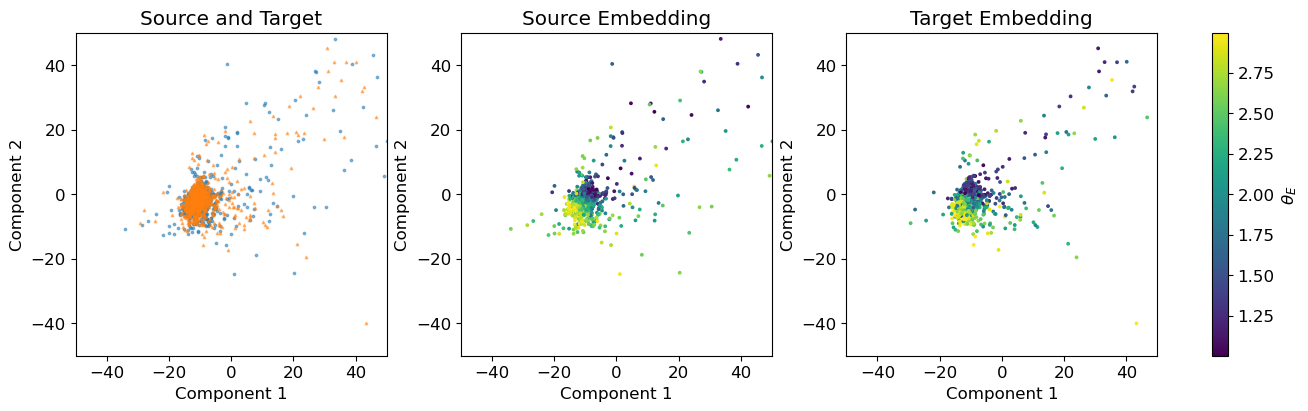


Epoch 240: 48.56s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0124
	Train Regression Loss: : 0.0112
	Train Mve Loss: : 9.1508
	Train R2 Score: : 0.9660
 Validation Statistics:
	Val Source Regression Loss: : 0.0111
	Val Target Regression Loss: : 0.0187
	Val Source R2 Score: : 0.9661
	Val Target R2 Score: : 0.9433
	Val Source Mve Loss: : 5.9071
	Val Target Mve Loss: : 1001.9182
	Val Source Nll Loss: : 5.9071
	Val Target Nll Loss: : 1001.9182

Epoch 241: 50.00s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0132
	Train Regression Loss: : 0.0112
	Train Mve Loss: : 17.5357
	Train R2 Score: : 0.9661
 Validation Statistics:
	Val Source Regression Loss: : 0.0115
	Val Target Regression Loss: : 0.0203
	Val Source R2 Score: : 0.9642
	Val Target R2 Score: : 0.9373
	Val Source Mve Loss: : 33.1300
	Val Target Mve Loss: : 2507.2845
	Val Source Nll Loss: : 33.1300
	Val Target Nll Loss: : 2507.2845

Epoch 242: 50.08s
----------------------------

In [10]:
print("Beginning Training...")

for curr_epoch in range(stats['epoch_no'], stats['epoch_no'] + n_epoch):

        # Generate isomaps every 20 epochs
        if (curr_epoch % 20 == 0):
            print("Generating Isomap...")
            source_iso, target_iso = generate_isomaps(source_data, target_data, model)
            show_isomaps(source_iso, 
                         target_iso, 
                         isomap_source_label_sample, 
                         isomap_target_label_sample, 
                         save_mod_name, 
                         name = stats["epoch_no"], 
                         axlim = 50, save = True)

        # Save best models
        if (len(stats['val_target_r2_score']) > 0):
            
            # Save and overwrite model every best target R2
            if (stats['val_target_r2_score'][-1] > best_target_R2):
                print("Saving Model...", end = ' ')
                save_model(save_mod_name, model, optimizer, stats)
                best_target_R2 = stats['val_target_r2_score'][-1]
                print("Done.")
                
            # Save and overwrite model every best target MVE Loss
            if (stats['val_target_mve_loss'][-1] < best_mve_loss):
                print("Saving Model MVE...", end = ' ')
                mve_name = save_mod_name + "_mve"
                save_model(mve_name, model, optimizer, stats)
                best_mve_loss = stats['val_target_mve_loss'][-1]
                print("Done.")

            # Save and overwrite model every best target MVE Loss
            if (stats['val_target_nll_loss'][-1] < best_nll_loss):
                print("Saving Model NLL...", end = ' ')
                nll_name = save_mod_name + "_nll"
                save_model(nll_name, model, optimizer, stats)
                best_nll_loss = stats['val_target_nll_loss'][-1]
                print("Done.")

        
        start_time = time.time()

        beta = beta_function(curr_epoch)
        da_weight = da_weight_function(curr_epoch)

        # Train, backpropagate
        vals = train_loop_mve(source_train_dataloader, 
                              target_train_dataloader, 
                              model,
                              regressor_loss_fn, 
                              da_loss_fn, 
                              optimizer,
                              da_weight, 
                              beta)

        # Test, validate metrics
        vals_validate = test_loop_mve(source_val_dataloader, 
                                      target_val_dataloader,
                                      model, 
                                      regressor_loss_fn, 
                                      beta)

        scheduler.step()

        # Training Metrics
        stats['train_DA_loss'].append(vals[0])
        stats['train_regression_loss'].append(vals[1])
        stats['train_mve_loss'].append(vals[2])
        stats['train_r2_score'].append(vals[3])

        # Validation Metrics
        stats['val_source_regression_loss'].append(vals_validate[0])
        stats['val_target_regression_loss'].append(vals_validate[1])
        stats['val_source_r2_score'].append(vals_validate[2])
        stats['val_target_r2_score'].append(vals_validate[3])
        stats['val_source_mve_loss'].append(vals_validate[4])
        stats['val_target_mve_loss'].append(vals_validate[5])
        stats['val_source_nll_loss'].append(vals_validate[6])
        stats['val_target_nll_loss'].append(vals_validate[7])
        
        # Other Parameters
        stats['da_weight'].append(da_weight)
        stats['beta'].append(beta)
        stats['epoch_no'] += 1
        #stats['lr'].append(scheduler.get_last_lr())
        print_epoch_scores(stats, curr_epoch, time.time() - start_time)

In [11]:
# Saves the end result model after running for all stages, as well as the .json of stats

state = {
    'epoch': stats['epoch_no'],
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}
final_mod_name = save_mod_name + "_final"
torch.save(state, final_mod_name)
json.dump(stats, open(final_mod_name+'.json', 'w'))

## Visualize Results

In [28]:
# Loads a model for plotting/viz

viz_mod_name = "models/papermve_v3_aug22_1315_C_mve" # "models/start_code_test_4_final"
model.load_state_dict(torch.load(viz_mod_name)['state_dict'])
stats = json.load(open(viz_mod_name+'.json', 'r'))

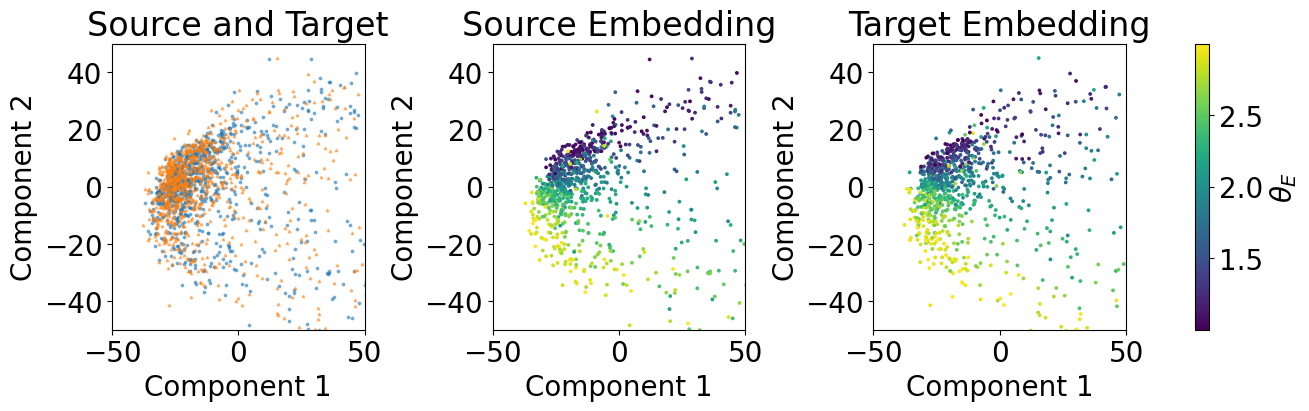

(<Figure size 1300x400 with 4 Axes>,
 array([<Axes: title={'center': 'Source and Target'}, xlabel='Component 1', ylabel='Component 2'>,
        <Axes: title={'center': 'Source Embedding'}, xlabel='Component 1', ylabel='Component 2'>,
        <Axes: title={'center': 'Target Embedding'}, xlabel='Component 1', ylabel='Component 2'>],
       dtype=object))

In [29]:
# Visualize isomaps 
trained_source_iso, trained_target_iso = generate_isomaps(source_data, target_data, model)
show_isomaps(trained_source_iso, trained_target_iso, isomap_source_label_sample, isomap_target_label_sample, viz_mod_name, axlim = 50)

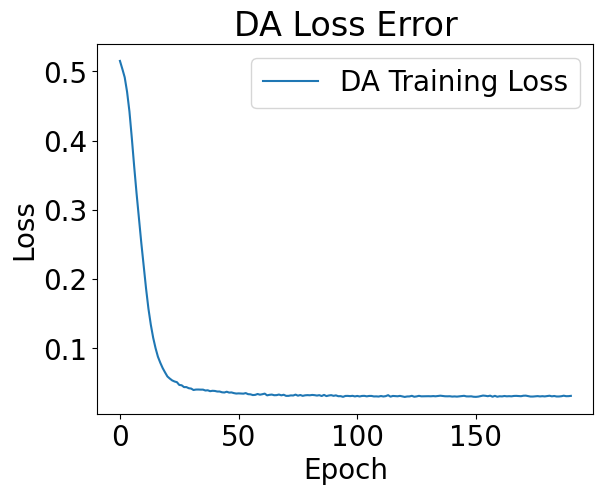

In [30]:
# DA Loss
fmt = lambda k: " ".join([i.capitalize() for i in k.split('_')])
eps = np.arange(stats["epoch_no"])
plt.title("DA Loss Error")
plt.plot(eps, stats['train_DA_loss'], label = "DA Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

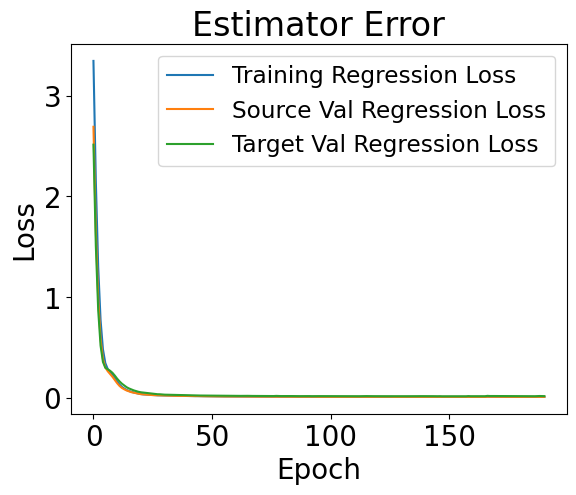

In [31]:
# Estimator / Regression
plt.title("Estimator Error")
plt.plot(eps, stats['train_regression_loss'], label = "Training Regression Loss")
plt.plot(eps, stats['val_source_regression_loss'], label = "Source Val Regression Loss")
plt.plot(eps, stats['val_target_regression_loss'], label = "Target Val Regression Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')

(-1.0, 1.0)

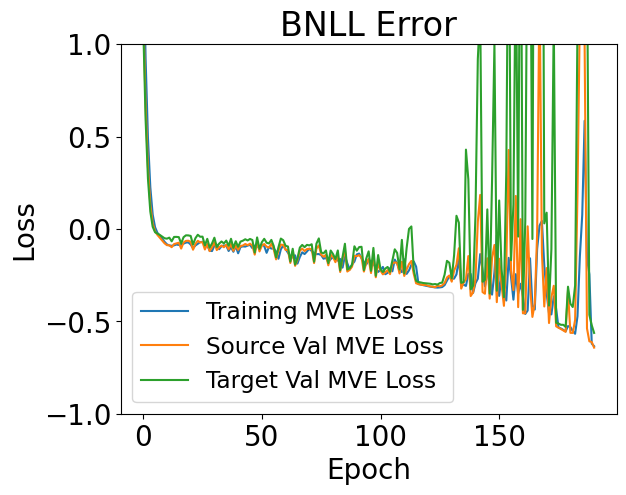

In [32]:
# BNLL for MVE
plt.title("BNLL Error")
plt.plot(eps, stats['train_mve_loss'], label = "Training MVE Loss")
plt.plot(eps, stats['val_source_mve_loss'], label = "Source Val MVE Loss")
plt.plot(eps, stats['val_target_mve_loss'], label = "Target Val MVE Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')
plt.ylim(-1, 1)

(0.5, 1.0)

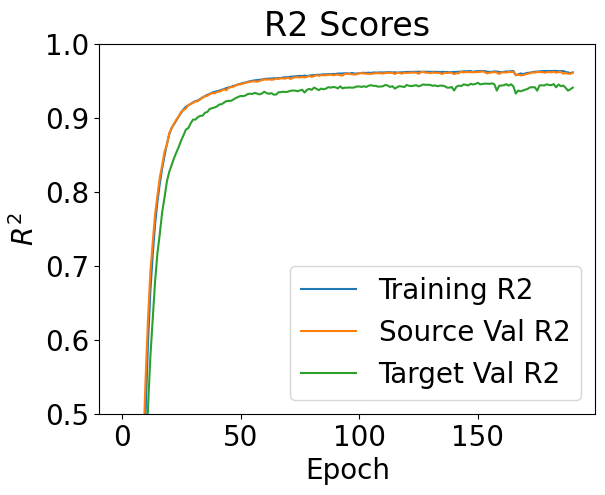

In [33]:
# R2 Scores
plt.title("R2 Scores")
plt.plot(eps, stats['train_r2_score'], label = "Training R2")
plt.plot(eps, stats['val_source_r2_score'], label = "Source Val R2")
plt.plot(eps, stats['val_target_r2_score'], label = "Target Val R2")
plt.xlabel("Epoch")
plt.ylabel("$R^2$")
plt.legend()
plt.ylim(0.5, 1)

In [34]:
# Test Source
var_preds_source = np.array([])
preds_source = np.array([])
true_source = np.array([])
lbnll_source = np.array([])
score_list = np.array([])

with torch.no_grad():
    for X, y in source_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds_source = np.append(preds_source, pred[:, 0].cpu())
        var_preds_source = np.append(var_preds_source, pred[:, 1].cpu())
        true_source = np.append(true_source, y.cpu())
        score = r2_score(y.cpu(), pred[:, 0].cpu())
        score_list = np.append(score_list, score)
        lbnll_source = np.append(lbnll_source, loss_bnll(pred[:, 0].cpu(), pred[:, 1].cpu(), y, beta = 0.5))

score = np.mean(score_list)
print(f'Source R2 Score is {score:.4f}')

Source R2 Score is 0.9613


Text(0.5, 1.0, 'MMD | Source | R2: 0.961')

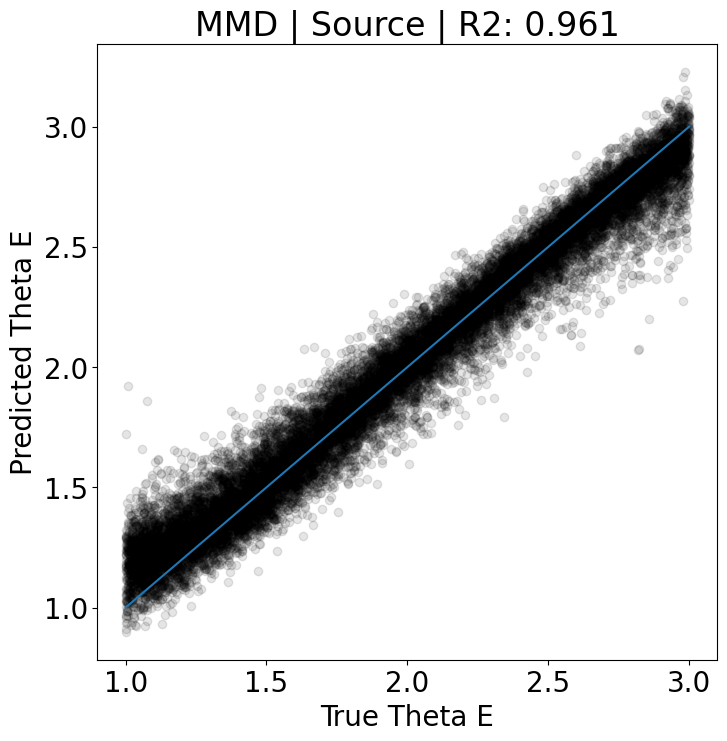

In [35]:
plt.figure(figsize=(8,8))
plt.scatter(true_source, preds_source,  color='black', alpha = 0.1)
line = np.linspace(1, 3, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Source | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'Uncertainty | Source | BNLL: -0.308')

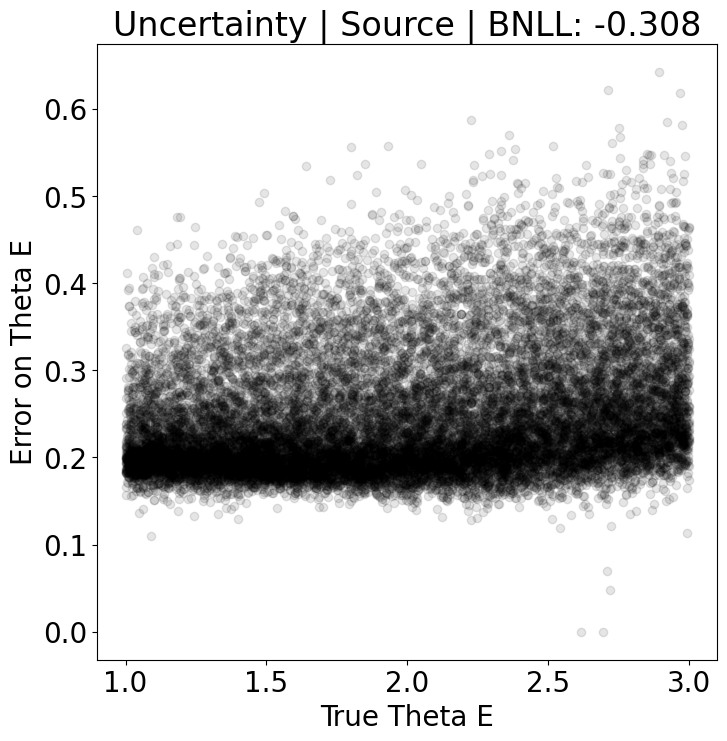

In [36]:
plt.figure(figsize=(8,8))
plt.scatter(true_source, np.sqrt(var_preds_source),  color='black', alpha = 0.1)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Error on Theta E');
plt.rc('font', size=20)
plt.title('Uncertainty | Source | BNLL: {0:.3f}'.format(np.mean(lbnll_source)))

In [37]:
# Test target
preds_target = np.array([])
var_preds_target = np.array([])
true_target = np.array([])
score_list = np.array([])
lbnll_target = np.array([])


with torch.no_grad():
    for X, y in target_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds_target = np.append(preds_target, pred[:, 0].cpu())
        var_preds_target = np.append(var_preds_target, pred[:, 1].cpu())
        true_target = np.append(true_target, y.cpu())
        score = r2_score(y.cpu(), pred[:, 0].cpu())
        score_list = np.append(score_list, score)
        lbnll_target = np.append(lbnll_target, loss_bnll(pred[:, 0].cpu(), pred[:, 1].cpu(), y, beta = 0.5))


score = np.mean(score_list)
print(f'Target R2 Score is {score:.4f}')

Target R2 Score is 0.9382


Text(0.5, 1.0, 'MMD | Target | R2: 0.938')

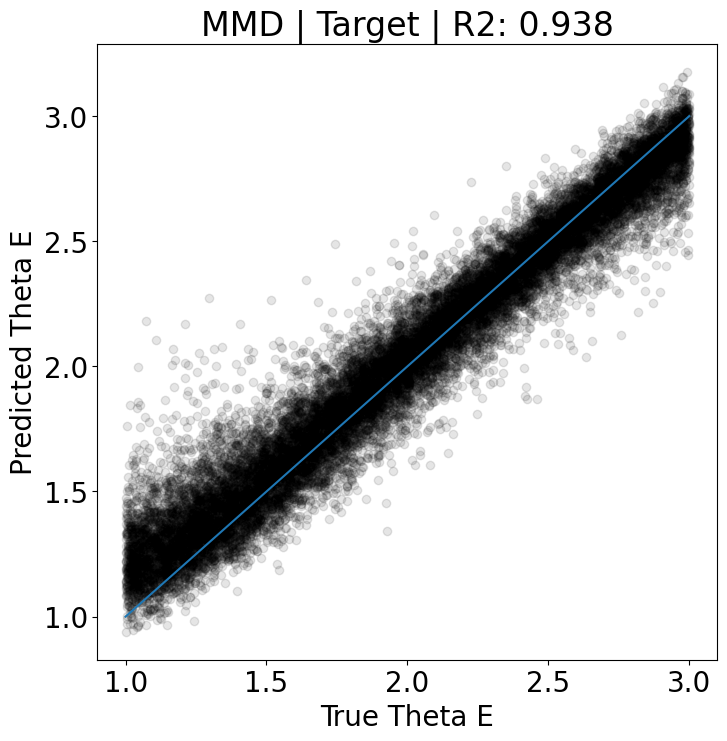

In [38]:
plt.figure(figsize=(8,8))
plt.scatter(true_target, preds_target,  color='black', alpha = 0.1)
line = np.linspace(1, 3, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'MMD | Target | R2: 0.938')

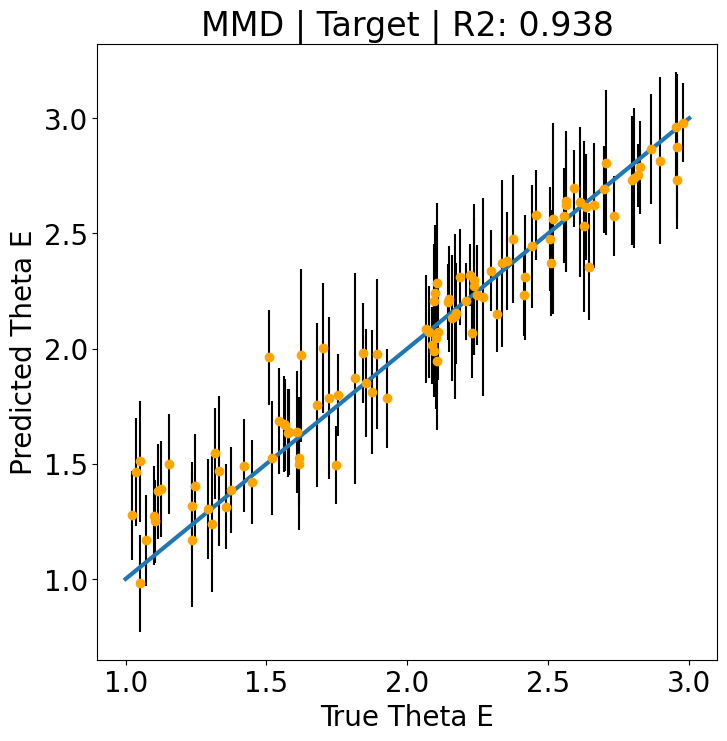

In [39]:
plt.figure(figsize=(8,8))
idx = np.random.choice(np.arange(len(true_target)), 100)
plt.errorbar(true_target[idx], preds_target[idx], yerr = np.sqrt(var_preds_target[idx]), fmt = 'o', color='orange', ecolor = 'k', alpha = 1)
line = np.linspace(1, 3, 100)
plt.plot(line, line, lw = 3)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'Uncertainty | Target | BNLL: -0.291')

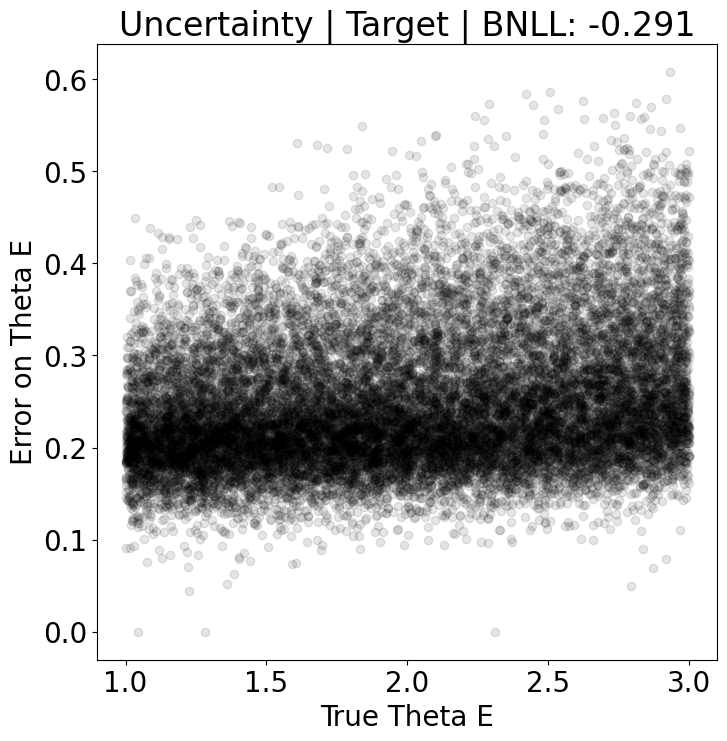

In [40]:
plt.figure(figsize=(8,8))
plt.scatter(true_target, np.sqrt(var_preds_target),  color='black', alpha = 0.1)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Error on Theta E');
plt.rc('font', size=20)
plt.title('Uncertainty | Target | BNLL: {0:.3f}'.format(np.mean(lbnll_target)))

In [41]:
def sample_variance(obs, true):
    return np.std(obs - true) ** 2

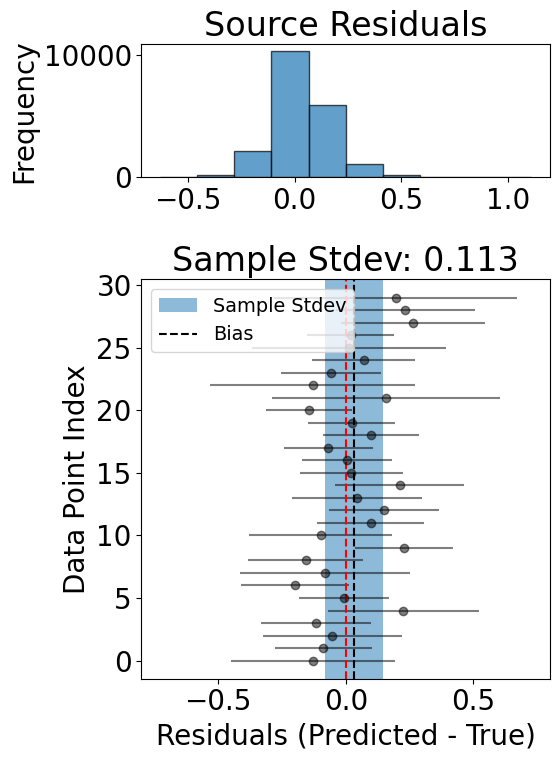

In [42]:
n_points = 30
rand_idx = np.random.choice(np.arange(len(preds_source)), n_points)
residuals = preds_source[rand_idx] - true_source[rand_idx]
resid_all = preds_target - true_target
errors = np.sqrt(var_preds_source[rand_idx])
sv = np.sqrt(sample_variance(preds_source, true_source))
mn = np.mean(resid_all)

# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))



# Plot the histogram
ax_hist.hist(resid_all, bins=10, edgecolor='black', alpha=0.7)
ax_hist.set_title('Source Residuals')
ax_hist.set_ylabel('Frequency')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=np.arange(n_points), xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k')
ax_resid.axvline(x=0, color='red', linestyle='--')
ax_resid.set_xlabel('Residuals (Predicted - True)')
ax_resid.set_ylabel('Data Point Index')
ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "Sample Stdev")
ax_resid.axvline(mn, color = 'k', ls = '--', label = "Bias")
ax_resid.legend(loc = 'upper left', fontsize = 'x-small')

plt.xlim(-0.8, 0.8)

plt.tight_layout()
plt.show()

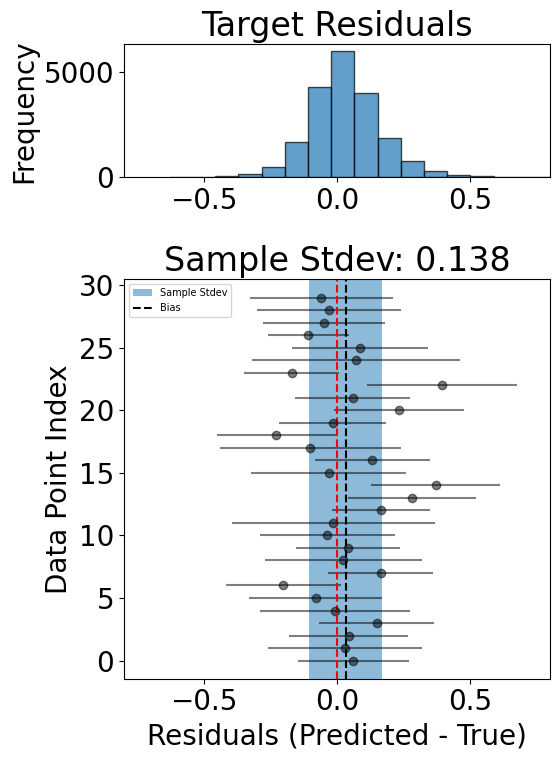

In [43]:
n_points = 30
rand_idx = np.random.choice(np.arange(len(preds_source)), n_points)
residuals = preds_target[rand_idx] - true_target[rand_idx]
resid_all = preds_target - true_target
errors = np.sqrt(var_preds_target[rand_idx])
sv = np.sqrt(sample_variance(preds_target, true_target))
mn = np.mean(resid_all)
# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))



# Plot the histogram
ax_hist.hist(resid_all, bins=20, edgecolor='black', alpha=0.7)
ax_hist.set_title('Target Residuals')
ax_hist.set_ylabel('Frequency')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=np.arange(n_points), xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k')
ax_resid.axvline(x=0, color='red', linestyle='--')
ax_resid.set_xlabel('Residuals (Predicted - True)')
ax_resid.set_ylabel('Data Point Index')
ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "Sample Stdev")
ax_resid.axvline(mn, color = 'k', ls = '--', label = "Bias")
ax_resid.legend(loc = 'upper left', fontsize = 7)
ax_resid.sharex(ax_hist)

plt.xlim(-0.8, 0.8)

plt.tight_layout()
plt.show()